# Plant Disease Prediction

In [1]:
!pip install mathplotlib

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement mathplotlib (from versions: none)
ERROR: No matching distribution found for mathplotlib


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import ResNet50


## Data Preprocessing

In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
  print("GPU is available!")
else:
  print("GPU is not available.")

GPU is available!


### Training Image preprocessing

In [3]:
training_set = tf.keras.utils.image_dataset_from_directory(
    'Plant Disease dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 70295 files belonging to 38 classes.


### Validation Image Preprocessing

In [4]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    'Plant Disease dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


#### To avoid Overshooting Loss function
1. Choose small learning rate default 0.001 here we have taken 0.0001
2. There may be chance of underfitting so increase number of neuron
3. Add more Convolutional Layer to extract more feature from images there may be possibilty that model unable to capture relevant feature or model is confusing due to lack of feature so feed with more feature

## Building Model

### Building Convolution Layer

In [5]:
# Load the ResNet-50 model without the top (fully connected) layers
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the weights of the pre-trained layers
for layer in resnet_model.layers:
    layer.trainable = False

# Add custom top layers
x = tf.keras.layers.Flatten()(resnet_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(38, activation='softmax')(x)

# Create the model
ResNet50_model = tf.keras.models.Model(inputs=resnet_model.input, outputs=output)

# Compile the model
ResNet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
ResNet50_model.summary()

# Train the model
history = ResNet50_model.fit(training_set,
                             validation_data=validation_set,
                             epochs=10)  # Adjust epochs as needed


94765736/94765736 [==============================] - 28s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizatio

## Evaluating Model

In [8]:
#Training set Accuracy
train_loss, train_acc = ResNet50_model.evaluate(training_set)
print('Training accuracy:', train_acc)

2197/2197 [==============================] - 125s 57ms/step - loss: 0.0062 - accuracy: 0.9981
Training accuracy: 0.9980510473251343


In [9]:
#Validation set Accuracy
val_loss, val_acc = ResNet50_model.evaluate(validation_set)
print('Validation accuracy:', val_acc)

550/550 [==============================] - 32s 58ms/step - loss: 0.1503 - accuracy: 0.9725
Validation accuracy: 0.972456157207489


### Saving Model

In [11]:
ResNet50_model.save('trained_plant_disease_model_resnet50.keras')

In [12]:
history.history #Return Dictionary of history

{'loss': [0.4543114900588989,
  0.16850751638412476,
  0.12177612632513046,
  0.09987758100032806,
  0.0873948261141777,
  0.07201670110225677,
  0.06482023000717163,
  0.05804888904094696,
  0.05429235100746155,
  0.050447072833776474],
 'accuracy': [0.8679564595222473,
  0.9475496411323547,
  0.9609929323196411,
  0.9697844982147217,
  0.9740521907806396,
  0.9789600968360901,
  0.9811935424804688,
  0.9835834503173828,
  0.9846788644790649,
  0.9859876036643982],
 'val_loss': [0.148018941283226,
  0.1371755599975586,
  0.13928546011447906,
  0.12371131777763367,
  0.11615774780511856,
  0.13043710589408875,
  0.12554921209812164,
  0.12835979461669922,
  0.12965233623981476,
  0.1502513289451599],
 'val_accuracy': [0.9528796076774597,
  0.9586842656135559,
  0.9615297317504883,
  0.967391312122345,
  0.9705781936645508,
  0.9680742025375366,
  0.9735374450683594,
  0.9716025590896606,
  0.9710903763771057,
  0.972456157207489]}

In [13]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(history.history,f)

In [14]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Accuracy Visualization

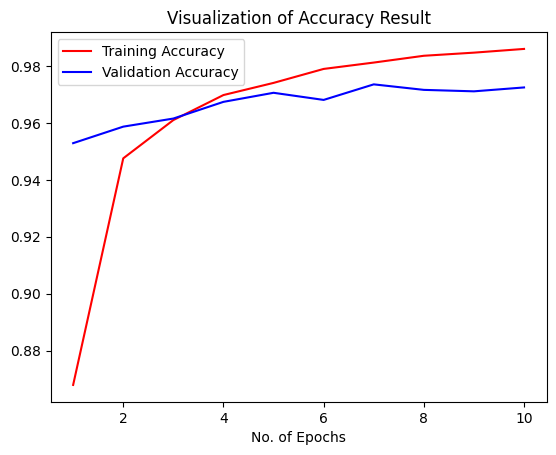

In [15]:
epochs = [i for i in range(1,11)]
plt.plot(epochs,history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

## Some other metrics for model evaluation

In [16]:
class_name = validation_set.class_names

In [17]:
test_set = tf.keras.utils.image_dataset_from_directory(
    'Plant Disease dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


In [19]:
y_pred = ResNet50_model.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

2197/2197 [==============================] - 134s 61ms/step


In [20]:
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [21]:
Y_true

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37], dtype=int64)>

In [22]:
predicted_categories

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37], dtype=int64)>

In [23]:
class_name = validation_set.class_names
print(class_name)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [24]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(Y_true,predicted_categories)

In [25]:
# Precision Recall Fscore
print(classification_report(Y_true,predicted_categories,target_names=class_name))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.97      0.98       504
                                 Apple___Black_rot       0.97      0.99      0.98       497
                          Apple___Cedar_apple_rust       1.00      0.97      0.98       440
                                   Apple___healthy       0.95      0.99      0.97       502
                               Blueberry___healthy       0.98      0.99      0.98       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.92      0.93       410
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.93      0.96      0.

### Confusion Matrix Visualization

In [26]:
import seaborn as sns

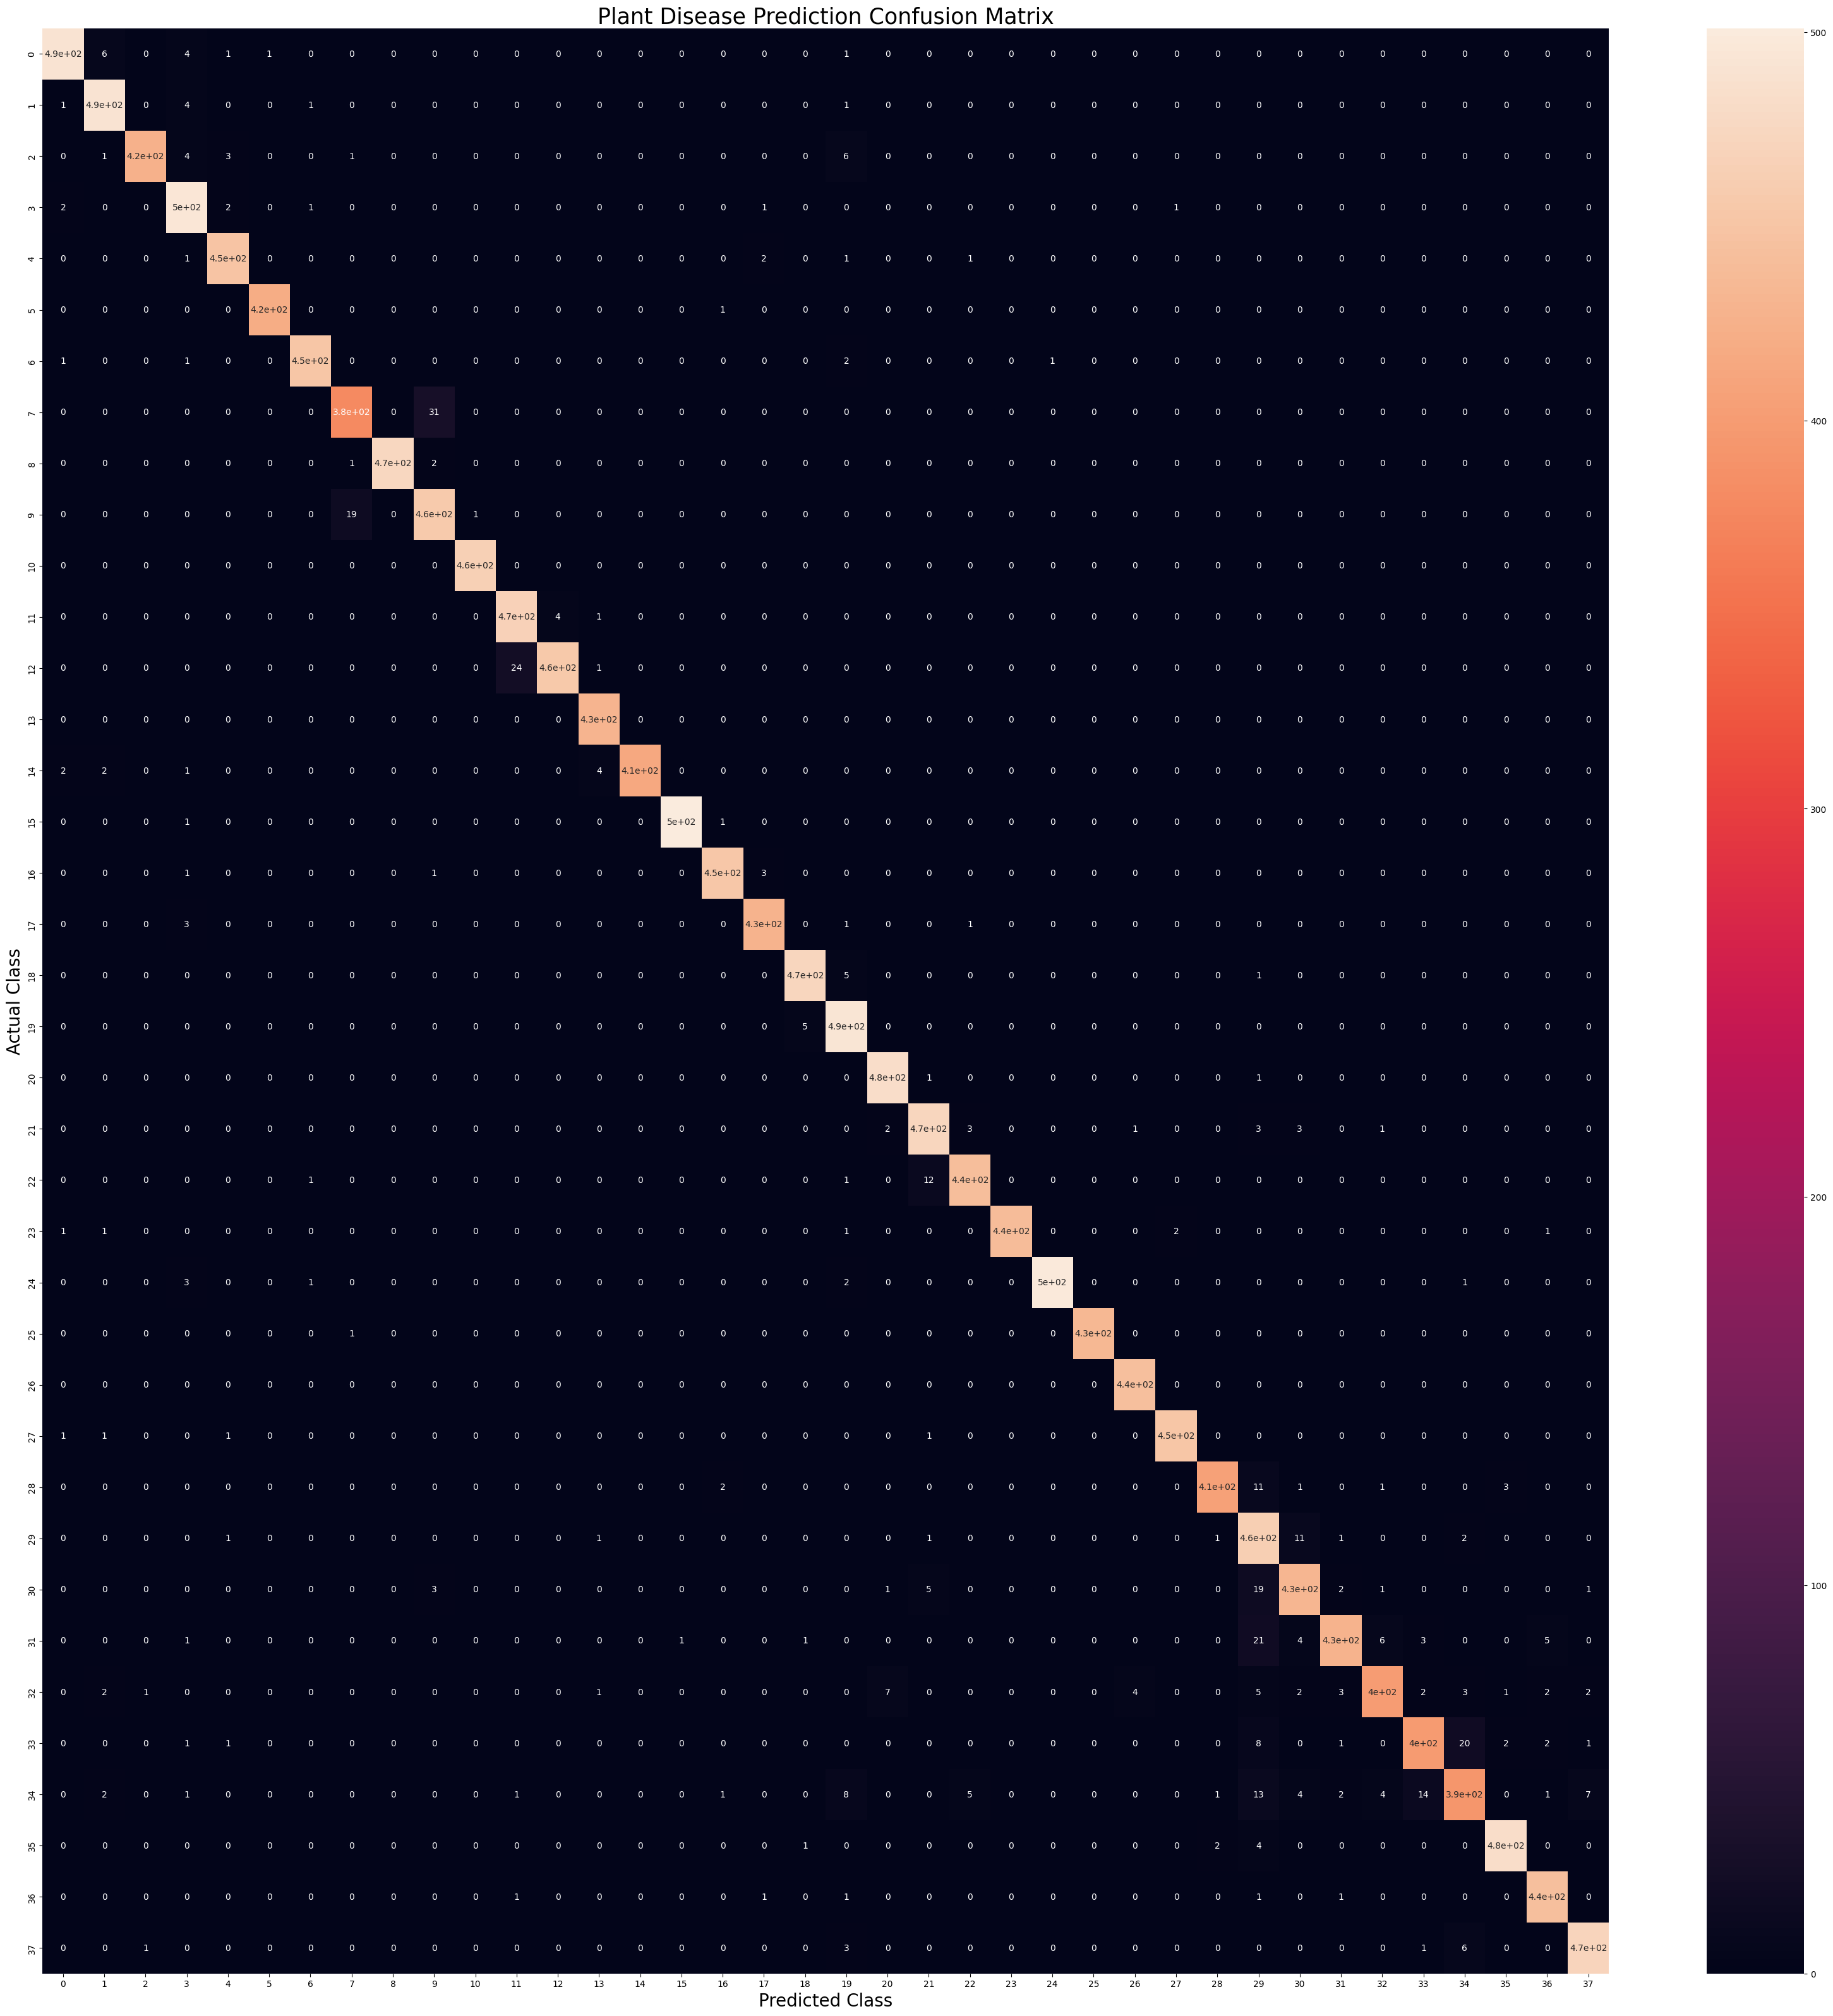

In [27]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()

Predctive System - Testing

In [28]:
validation_set = tf.keras.utils.image_dataset_from_directory(
   'Plant Disease dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
class_name = validation_set.class_names
print(class_name)

Found 17572 files belonging to 38 classes.
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Tw

In [29]:
# cnn = tf.keras.models.load_model('trained_plant_disease_model.keras')

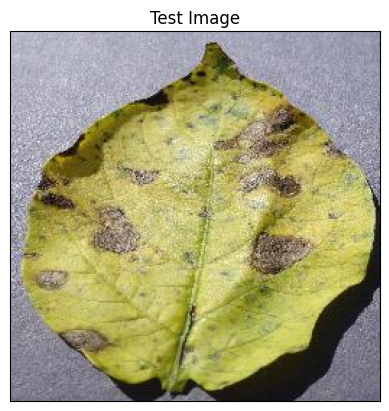

In [30]:
#Test Image Visualization
import cv2
import numpy as np
image_path = 'Plant Disease dataset/test/test/PotatoEarlyBlight4.JPG'
# Reading an image in default mode
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image 
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [31]:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(128,128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = cnn.predict(input_arr)

NameError: name 'cnn' is not defined

In [ ]:
print(predictions)

In [ ]:
result_index = np.argmax(predictions) #Return index of max element
print(result_index)

In [ ]:
# Displaying the disease prediction
model_prediction = class_name[result_index]
plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()